In [1]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
import shutil


# Augmentation

In [ ]:
RAW_DIR = "/content/drive/MyDrive/dataset_raw"
FINAL_DIR = "/content/drive/MyDrive/dataset_final"

IMG_SIZE = 224
TARGET_PER_CLASS = 80
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15


In [ ]:
def augment_image(img):
    h, w = img.shape

    # Small rotation (SEM-safe)
    angle = random.uniform(-4, 4)
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    # Flip
    if random.random() < 0.5:
        img = cv2.flip(img, 1)
    if random.random() < 0.5:
        img = cv2.flip(img, 0)

    # Mild contrast (SEM detector gain)
    alpha = random.uniform(0.96, 1.04)

    # Mild brightness (beam current variation)
    beta = random.randint(-6, 6)

    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    return img


In [ ]:
import os
import cv2
import random
import numpy as np

for cls in os.listdir(RAW_DIR):
    print(f"\nProcessing class: {cls}")

    cls_dir = os.path.join(RAW_DIR, cls)
    img_files = os.listdir(cls_dir)
    random.shuffle(img_files)

    images = []

    # 1️⃣ Load all original images
    for img_name in img_files:
        img_path = os.path.join(cls_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)

    # 2️⃣ Augment until we have at least TARGET_PER_CLASS
    augmented = images.copy()

    while len(augmented) < TARGET_PER_CLASS:
        src = random.choice(images)
        aug = augment_image(src)   # your SEM-safe augment
        augmented.append(aug)

    # 3️⃣ 🔒 CAP TO EXACTLY 80 (THIS IS THE IMPORTANT LINE)
    augmented = augmented[:TARGET_PER_CLASS]

    random.shuffle(augmented)

    # 4️⃣ Split EXACTLY 56 / 12 / 12
    n_train = int(TRAIN_RATIO * TARGET_PER_CLASS)  # 56
    n_val = int(VAL_RATIO * TARGET_PER_CLASS)      # 12

    splits = {
        "train": augmented[:n_train],
        "val": augmented[n_train:n_train+n_val],
        "test": augmented[n_train+n_val:]
    }

    # 5️⃣ Save
    for split, imgs in splits.items():
        out_dir = os.path.join(FINAL_DIR, split, cls)
        os.makedirs(out_dir, exist_ok=True)

        for i, img in enumerate(imgs):
            out_path = os.path.join(out_dir, f"{cls}_{i}.png")
            cv2.imwrite(out_path, img)



Processing class: Normal

Processing class: Other

Processing class: LER

Processing class: CMP

Processing class: Line Collapse

Processing class: Opens

Processing class: Particle

Processing class: Bridge


In [ ]:
for split in ["train","val","test"]:
    print("------------------")
    print(split)
    print("------------------")
    for cls in os.listdir(os.path.join(FINAL_DIR, split)):
        print(cls, len(os.listdir(os.path.join(FINAL_DIR, split, cls))))


------------------
train
------------------
Normal 56
Other 56
LER 56
CMP 56
Line Collapse 56
Opens 56
Particle 56
Bridge 56
------------------
val
------------------
Normal 12
Other 12
LER 12
CMP 12
Line Collapse 12
Opens 12
Particle 12
Bridge 12
------------------
test
------------------
Normal 12
Other 12
LER 12
CMP 12
Line Collapse 12
Opens 12
Particle 12
Bridge 12


In [46]:
MERGED_DIR = "/content/drive/MyDrive/dataset_merged"   # has 80
FINAL_DIR   = "/content/drive/MyDrive/Deeptech_dataset"     # want 100
TARGET_PER_CLASS = 100
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15

In [47]:
def augment_image_extra(img):
    if random.random() < 0.5:
        noise = np.random.normal(0, 2, img.shape)
        img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    if random.random() < 0.4:
        img = cv2.GaussianBlur(img, (3,3), 0)

    return img


In [48]:
for cls in os.listdir(MERGED_DIR):
    cls_dir = os.path.join(MERGED_DIR, cls)
    imgs = [f for f in os.listdir(cls_dir) if f.endswith(('.png','.jpg','.jpeg'))]

    while len(imgs) < TARGET_PER_CLASS:
        src = random.choice(imgs)
        img = cv2.imread(os.path.join(cls_dir, src), cv2.IMREAD_GRAYSCALE)
        aug = augment_image_extra(img)

        out_name = f"aug_{len(imgs)}.png"
        cv2.imwrite(os.path.join(cls_dir, out_name), aug)
        imgs.append(out_name)


In [49]:
for cls in os.listdir(MERGED_DIR):
    cls_dir = os.path.join(MERGED_DIR, cls)
    imgs = os.listdir(cls_dir)
    random.shuffle(imgs)

    n_train = int(0.7 * len(imgs))   # 70
    n_val   = int(0.15 * len(imgs))  # 15

    splits = {
        "train": imgs[:n_train],
        "val": imgs[n_train:n_train+n_val],
        "test": imgs[n_train+n_val:]
    }

    for split, split_imgs in splits.items():
        out_dir = os.path.join(FINAL_DIR, split, cls)
        os.makedirs(out_dir, exist_ok=True)

        for img in split_imgs:
            shutil.copy(
                os.path.join(cls_dir, img),
                os.path.join(out_dir, img)
            )


In [50]:
for split in ["train","val","test"]:
    print("------------------")
    print(split)
    print("------------------")
    for cls in os.listdir(os.path.join(FINAL_DIR, split)):
        print(cls, len(os.listdir(os.path.join(FINAL_DIR, split, cls))))


------------------
train
------------------
Normal 70
Other 70
LER 70
CMP 70
Line Collapse 70
Opens 70
Particle 70
Bridge 70
------------------
val
------------------
Normal 15
Other 15
LER 15
CMP 15
Line Collapse 15
Opens 15
Particle 15
Bridge 15
------------------
test
------------------
Normal 15
Other 15
LER 15
CMP 15
Line Collapse 15
Opens 15
Particle 15
Bridge 15


In [76]:
total = 0

for split in ["train", "val", "test"]:
    split_dir = os.path.join(FINAL_DIR, split)

    for cls in os.listdir(split_dir):
        cls_dir = os.path.join(split_dir, cls)
        if os.path.isdir(cls_dir):
            total += len(os.listdir(cls_dir))

print("Total images in dataset:", total)


Total images in dataset: 800


In [79]:
import shutil

DATASET_DIR = "/content/drive/MyDrive/Deeptech_dataset"
ZIP_PATH = "/content/drive/MyDrive/dataset.zip"

shutil.make_archive(
    base_name=ZIP_PATH.replace(".zip", ""),
    format="zip",
    root_dir=DATASET_DIR
)

print("Dataset zipped successfully!")


Dataset zipped successfully!


# Training model

In [2]:
!pip install torchvision

In [2]:
import torchvision
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
class WaferDefectNet(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()

        self.backbone = models.mobilenet_v2(
            weights=None,
            width_mult=0.5
        )

        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        return self.backbone(x)


In [4]:
model = WaferDefectNet()
x = torch.randn(1, 1, 224, 224)
y = model(x)
print(y.shape)


torch.Size([1, 8])


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [6]:
model.to(device)

WaferDefectNet(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(8, 48, kernel_size=(

In [56]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [57]:
DATA_DIR = "/content/drive/MyDrive/Deeptech_dataset"
BATCH_SIZE = 16

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transform)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"),   transform=val_transform)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)


Classes: ['Bridge', 'CMP', 'LER', 'Line Collapse', 'Normal', 'Opens', 'Other', 'Particle']


In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [59]:
from tqdm import tqdm

EPOCHS = 30
best_val_acc = 0.0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):

    # -------- TRAIN --------
    model.train()
    train_loss, train_correct = 0.0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [TRAIN]"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss /= len(train_ds)
    train_acc = train_correct / len(train_ds)

    # -------- VALIDATION --------
    model.eval()
    val_loss, val_correct = 0.0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [VAL]"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(val_ds)
    val_acc = val_correct / len(val_ds)

    # -------- STORE METRICS --------
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_final.pth")


Epoch 1/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 11.18it/s]


Epoch 1/30 | Train Acc: 0.2214 | Val Acc: 0.1250


Epoch 2/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 15.92it/s]


Epoch 2/30 | Train Acc: 0.3857 | Val Acc: 0.3167


Epoch 3/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 15.79it/s]


Epoch 3/30 | Train Acc: 0.4821 | Val Acc: 0.6083


Epoch 4/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 12.72it/s]


Epoch 4/30 | Train Acc: 0.5732 | Val Acc: 0.7000


Epoch 5/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 15.86it/s]


Epoch 5/30 | Train Acc: 0.6625 | Val Acc: 0.7667


Epoch 6/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 16.35it/s]


Epoch 6/30 | Train Acc: 0.6429 | Val Acc: 0.6000


Epoch 7/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 13.39it/s]


Epoch 7/30 | Train Acc: 0.6839 | Val Acc: 0.7083


Epoch 8/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 15.91it/s]


Epoch 8/30 | Train Acc: 0.7446 | Val Acc: 0.8417


Epoch 9/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 15.83it/s]


Epoch 9/30 | Train Acc: 0.7768 | Val Acc: 0.7833


Epoch 10/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 13.15it/s]


Epoch 10/30 | Train Acc: 0.7821 | Val Acc: 0.8333


Epoch 11/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 16.02it/s]


Epoch 11/30 | Train Acc: 0.8000 | Val Acc: 0.9250


Epoch 12/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 11.22it/s]


Epoch 12/30 | Train Acc: 0.7964 | Val Acc: 0.8500


Epoch 13/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 12.24it/s]


Epoch 13/30 | Train Acc: 0.8214 | Val Acc: 0.9000


Epoch 14/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 15.68it/s]


Epoch 14/30 | Train Acc: 0.8714 | Val Acc: 0.9083


Epoch 15/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 16.30it/s]


Epoch 15/30 | Train Acc: 0.8375 | Val Acc: 0.9167


Epoch 16/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 12.98it/s]


Epoch 16/30 | Train Acc: 0.8196 | Val Acc: 0.8833


Epoch 17/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 14.81it/s]


Epoch 17/30 | Train Acc: 0.8696 | Val Acc: 0.9417


Epoch 18/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 14.75it/s]


Epoch 18/30 | Train Acc: 0.8839 | Val Acc: 0.9667


Epoch 19/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 13.22it/s]


Epoch 19/30 | Train Acc: 0.8839 | Val Acc: 0.9583


Epoch 20/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 16.13it/s]


Epoch 20/30 | Train Acc: 0.8857 | Val Acc: 0.9167


Epoch 21/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 15.94it/s]


Epoch 21/30 | Train Acc: 0.9054 | Val Acc: 0.9417


Epoch 22/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 13.08it/s]


Epoch 22/30 | Train Acc: 0.9107 | Val Acc: 0.9500


Epoch 23/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 16.15it/s]


Epoch 23/30 | Train Acc: 0.8750 | Val Acc: 0.9333


Epoch 24/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 15.78it/s]


Epoch 24/30 | Train Acc: 0.8946 | Val Acc: 0.9583


Epoch 25/30 [VAL]: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]


Epoch 25/30 | Train Acc: 0.9179 | Val Acc: 0.9583


Epoch 26/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 15.85it/s]


Epoch 26/30 | Train Acc: 0.9125 | Val Acc: 0.9917


Epoch 27/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 15.89it/s]


Epoch 27/30 | Train Acc: 0.9375 | Val Acc: 0.9833


Epoch 28/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 12.92it/s]


Epoch 28/30 | Train Acc: 0.9321 | Val Acc: 0.9833


Epoch 29/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 29/30 | Train Acc: 0.9179 | Val Acc: 0.9833


Epoch 30/30 [VAL]: 100%|██████████| 8/8 [00:00<00:00, 15.90it/s]

Epoch 30/30 | Train Acc: 0.9232 | Val Acc: 0.9833


In [8]:
model.load_state_dict(torch.load("best_model_final.pth"))


<All keys matched successfully>

Visualising the accuracies and loss

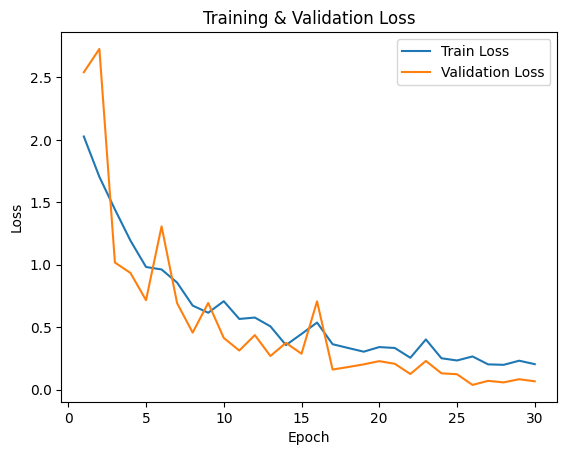

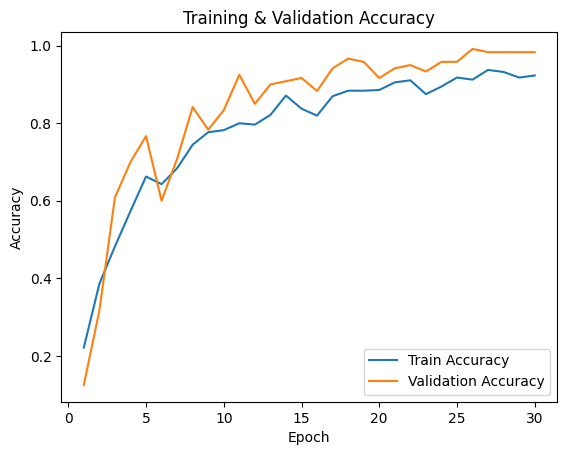

In [62]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()


Test Accuracy

In [63]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9833


Visualising images with their labels and model prediction

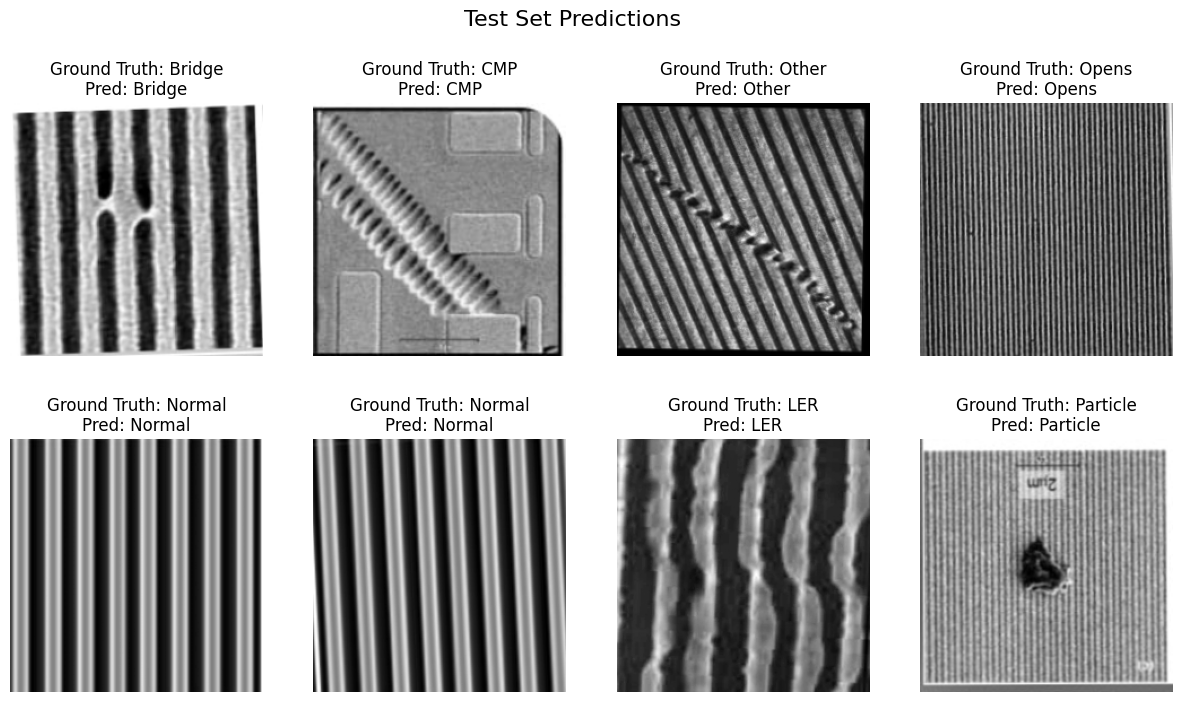

In [72]:
import numpy as np
import random
import matplotlib.pyplot as plt

def denormalize(img):
    img = img * 0.5 + 0.5  # reverse normalize
    return img.clamp(0, 1)

model.eval()

num_images = 8
indices = random.sample(range(len(test_ds)), num_images)

plt.figure(figsize=(15, 8))

for i, idx in enumerate(indices):
    img, label = test_ds[idx]

    input_img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_img)
        pred = output.argmax(1).item()

    img_disp = denormalize(img).squeeze().cpu().numpy()

    plt.subplot(2, 4, i+1)
    plt.imshow(img_disp, cmap="gray")
    plt.title(f"Ground Truth: {class_names[label]}\nPred: {class_names[pred]}")
    plt.axis("off")

plt.suptitle("Test Set Predictions", fontsize=16)
plt.show()


Visualising misclassified images

In [69]:
import torch

model.eval()

misclassified = []

with torch.no_grad():
    for idx in range(len(test_ds)):
        img, label = test_ds[idx]

        input_img = img.unsqueeze(0).to(device)
        output = model(input_img)
        pred = output.argmax(1).item()

        if pred != label:
            misclassified.append((idx, img.cpu(), label, pred))


In [70]:
print(f"Total misclassified samples: {len(misclassified)}")


Total misclassified samples: 2


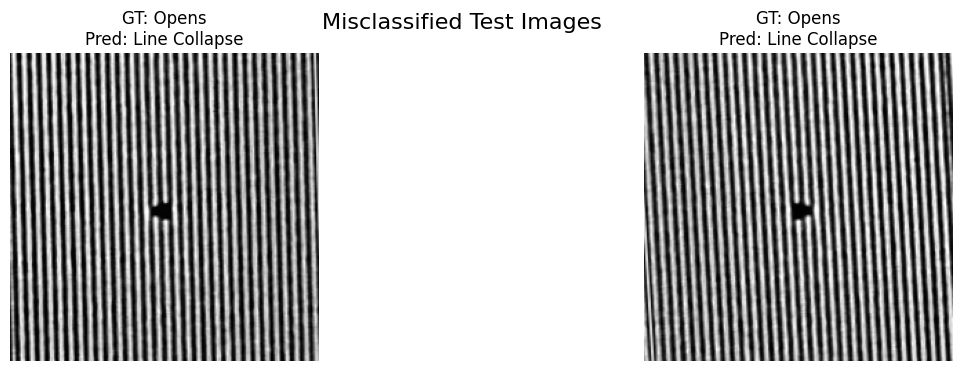

In [71]:
def denormalize(img):
    img = img * 0.5 + 0.5
    return img.clamp(0, 1)

num_show = min(8, len(misclassified))

plt.figure(figsize=(15, 4))

for i in range(num_show):
    idx, img, label, pred = misclassified[i]

    img_disp = denormalize(img).squeeze().numpy()

    plt.subplot(1, num_show, i + 1)
    plt.imshow(img_disp, cmap="gray")
    plt.title(f"GT: {class_names[label]}\nPred: {class_names[pred]}")
    plt.axis("off")

plt.suptitle("Misclassified Test Images", fontsize=16)
plt.show()


In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


In [65]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [73]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[15  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0]
 [ 0  0  0  0 15  0  0  0]
 [ 0  0  0  2  0 13  0  0]
 [ 0  0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0  0 15]]


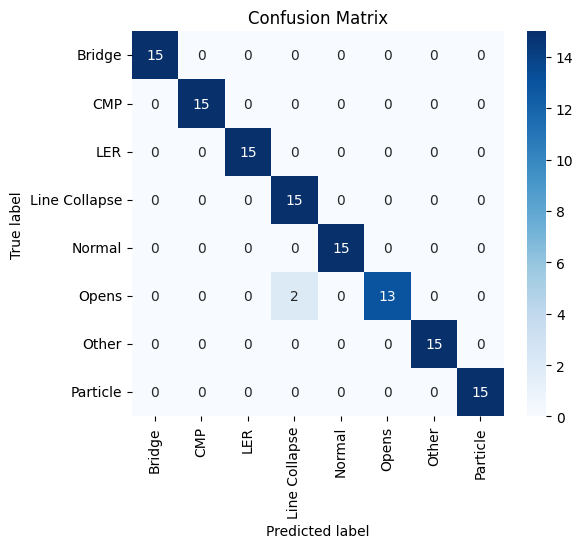

In [74]:
# Confusion Matrix as Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()


In [75]:
# Classification Report
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=3
))


               precision    recall  f1-score   support

       Bridge      1.000     1.000     1.000        15
          CMP      1.000     1.000     1.000        15
          LER      1.000     1.000     1.000        15
Line Collapse      0.882     1.000     0.938        15
       Normal      1.000     1.000     1.000        15
        Opens      1.000     0.867     0.929        15
        Other      1.000     1.000     1.000        15
     Particle      1.000     1.000     1.000        15

     accuracy                          0.983       120
    macro avg      0.985     0.983     0.983       120
 weighted avg      0.985     0.983     0.983       120



# Exporting the model to ONNX format

In [10]:
!pip install onnx onnxscript


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 19.7 MB/s eta 0:00:00


In [23]:
dummy_input = torch.randn(1, 1, 224, 224).to(device)

torch.onnx.export(
    model,
    dummy_input,
    "/content/drive/MyDrive/wafer_defect_model.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)


/tmp/ipython-input-2213921657.py:3: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0208 14:22:50.135000 1553 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features
W0208 14:22:50.881000 1553 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, ali

[torch.onnx] Obtain model graph for `WaferDefectNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `WaferDefectNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

Applied 104 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[s77,1,224,224]>
            ),
            outputs=(
                %"output"<FLOAT,[1,8]>
            ),
            initializers=(
                %"backbone.features.0.0.weight"<FLOAT,[16,3,3,3]>{Tensor(...)},
                %"backbone.features.1.conv.0.0.weight"<FLOAT,[16,1,3,3]>{Tensor(...)},
                %"backbone.features.1.conv.1.weight"<FLOAT,[8,16,1,1]>{Tensor(...)},
                %"backbone.features.2.conv.0.0.weight"<FLOAT,[48,8,1,1]>{Tensor(...)},
                %"backbone.features.2.conv.1.0.weight"<FLOAT,[48,1,3,3]>{Tensor(...)},
                %"backbone.features.2.conv.2.weight"<FLOAT,[16,48,1,1]>{Tensor(...)},
            

In [24]:
import onnx
onnx_model = onnx.load("/content/drive/MyDrive/wafer_defect_model.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid")


ONNX model is valid


In [25]:
import os

base = "/content/drive/MyDrive/Deeptech Hackathon/wafer_defect_model.onnx"
data = "/content/drive/MyDrive/Deeptech Hackathon/wafer_defect_model.onnx.data"

size_base = os.path.getsize(base)
size_data = os.path.getsize(data)

total_mb = (size_base + size_data) / (1024**2)

print(f"Total ONNX model size: {total_mb:.2f} MB")


Total ONNX model size: 2.90 MB


In [16]:
!pip install onnxruntime onnxruntime-tools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.6 MB/s eta 0:00:00


In [15]:
import onnx

model_onnx = onnx.load("/content/drive/MyDrive/Deeptech Hackathon/wafer_defect_model.onnx")

onnx.save(
    model_onnx,
    "/content/drive/MyDrive/Deeptech Hackathon/wafer_defect_model_single.onnx",
    save_as_external_data=False
)

print("Single-file ONNX created")


Single-file ONNX created


In [20]:
!pip install onnxconverter-common


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.5/89.5 kB 4.9 MB/s eta 0:00:00


In [21]:
import onnx
from onnxconverter_common import float16

# Load your single-file ONNX
model_fp32 = onnx.load("/content/drive/MyDrive/Deeptech Hackathon/wafer_defect_model_single.onnx")

# Convert to FP16
model_fp16 = float16.convert_float_to_float16(model_fp32)

# Save
onnx.save(model_fp16, "/content/drive/MyDrive/Deeptech Hackathon/wafer_defect_model_fp16.onnx")

print("FP16 conversion successful.")


FP16 conversion successful.


/usr/local/lib/python3.12/dist-packages/onnxconverter_common/float16.py:70: UserWarning: the float32 number -9.389849253693683e-08 will be truncated to -1e-07
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/onnxconverter_common/float16.py:70: UserWarning: the float32 number -3.1472787043185235e-08 will be truncated to -1e-07
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/onnxconverter_common/float16.py:52: UserWarning: the float32 number 3.859973674025241e-08 will be truncated to 1e-07
  warnings.warn(


In [22]:
import os

size_mb = os.path.getsize(
    "/content/drive/MyDrive/Deeptech Hackathon/wafer_defect_model_fp16.onnx"
) / (1024**2)

print(f"FP16 model size: {size_mb:.2f} MB")


FP16 model size: 1.58 MB
